In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model

In [2]:
!nvidia-smi

Sun Feb 12 06:33:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
df = pd.read_csv('/content/drive/MyDrive/TimeSeries/Gemini_ETHUSD_d.csv',  skiprows=1, parse_dates=True, index_col='Date')
df = df.sort_index().drop(['Symbol','Unix Timestamp'] , axis=1)
df.head()

,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,
2016-05-09,12.00,12.00,9.36,9.98,1317.90,12885.06
2016-05-10,9.98,9.98,9.36,9.68,672.06,6578.20
2016-05-11,9.68,10.47,9.68,10.43,3052.51,30978.11
2016-05-12,10.43,12.00,9.92,10.20,2072.56,22183.39
2016-05-13,10.20,11.59,10.20,10.69,1769.71,18923.55


# LSTM을 활용한 예측.

In [6]:
df

,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,
2016-05-09,12.00,12.00,9.36,9.98,1317.900,12885.06
2016-05-10,9.98,9.98,9.36,9.68,672.060,6578.20
2016-05-11,9.68,10.47,9.68,10.43,3052.510,30978.11
2016-05-12,10.43,12.00,9.92,10.20,2072.560,22183.39
2016-05-13,10.20,11.59,10.20,10.69,1769.710,18923.55
...,...,...,...,...,...,...
2020-11-16,448.97,466.22,446.16,460.73,10214.630,4680880.22
2020-11-17,460.73,485.05,460.23,482.81,21579.440,10262735.24
2020-11-18,482.81,495.76,459.14,479.49,32772.610,15638074.52


In [7]:
test_cutoff_date = df.index.max() - timedelta(days=90) # 마지막으로부터 90일치를 test로 쓰고, 나머지는 train

df_test = df[df.index > test_cutoff_date]['Close']
df_train = df[df.index <= test_cutoff_date]['Close']


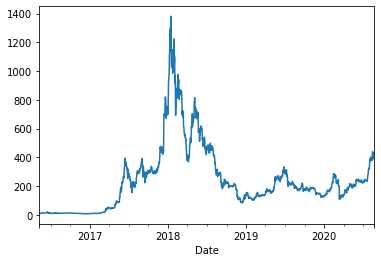

In [8]:
df_train.plot()

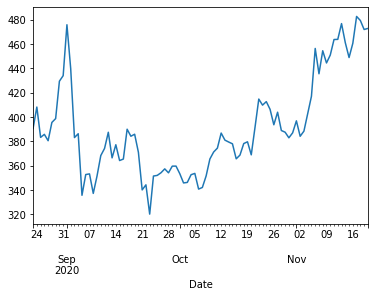

In [9]:
df_test.plot()

Single Step => 1일치 예측.

In [10]:
# CV (교차검증) 데이터를 만드는 과정. 

from numpy import array

# Blocking 방법으로 교차검증 데이터를 만드는 과정.
#                  시계열,     train 시퀀스 길이=30, 예측 값의 길이=1.
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
 #    0              100
 #    1              100
	for i in range(len(sequence)): 
		end_ix = i + n_steps_in # train 시퀀스의 끝 index를 계산.
		out_end_ix = end_ix + n_steps_out # 예측 시퀀스의 끝 index 계산.
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x) # 0,30 / 1,31 / 2,32 ...... 69 / 99
		y.append(seq_y) # 31 / 32 / 33 ..........  100
	return array(X), array(y)

raw_seq = df_train # train seq를 block cv가 가능하도록 쪼갠다.
n_steps_in = 30 # 30일치를 보고
n_steps_out = 1 # 1일을 맞추는 코드.

X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [11]:
X.shape

(1537, 30, 1)

In [12]:
y.shape

(1537, 1)

In [13]:
# Model을 만들기 시작하는 부분

from keras.models import Sequential
from keras.layers import LSTM, Dropout, SimpleRNN, GRU
from keras.layers import Dense # NN

In [34]:
model = Sequential() # 순차적 모델.
              # NN의 차원 => 32개의 히든 레이어
# model.add(layer)
              # 차원의 갯수 = 히든레이어 유닛 갯수.
model.add(LSTM(1024, activation='sigmoid',  # Many To Many
                            # n_steps_in=30, n_features = 1
               input_shape=(n_steps_in, 1), return_sequences=True)) # return_sequences default = False
model.add(Dropout(0.5))
model.add(LSTM(1024, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(1024, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.5))
# # #               # NN 차원 = 128개의 히든레이어
model.add(LSTM(1024, activation='sigmoid', return_sequences=True)) # Many to One
model.add(Dropout(0.5))
model.add(LSTM(1024, activation='sigmoid', return_sequences=False))
model.add(Dense(1)) # Dense = 바닐라 NN

# 모델이 학습할 방법을 지정해준다.
#              Gradiant 계산 방법, loss 함수 ?Mean Absolute Error
#                                loss = mae, mse = Mean Squared Error => 오차가 큰 경우에 패널티가 커짐.
model.compile(optimizer='adam', loss='mse')

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 1024)          4202496   
                                                                 
 dropout_4 (Dropout)         (None, 30, 1024)          0         
                                                                 
 lstm_7 (LSTM)               (None, 30, 1024)          8392704   
                                                                 
 dropout_5 (Dropout)         (None, 30, 1024)          0         
                                                                 
 lstm_8 (LSTM)               (None, 30, 1024)          8392704   
                                                                 
 dropout_6 (Dropout)         (None, 30, 1024)          0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 1024)         

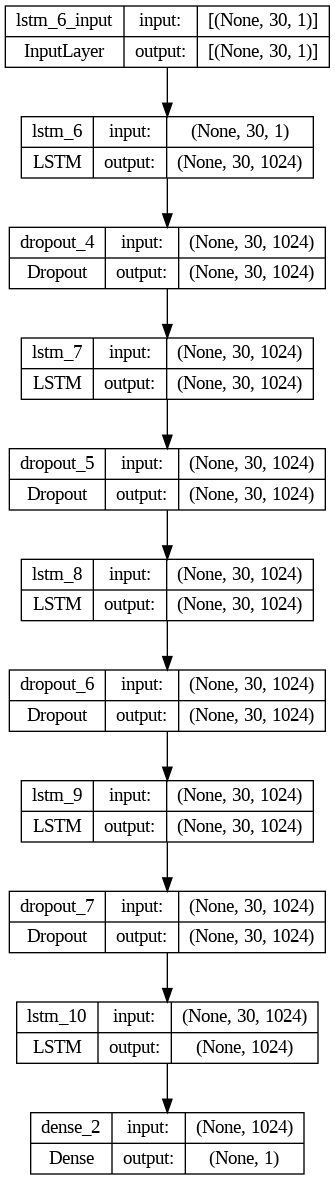

In [36]:
plot_model(model, show_shapes=True)

In [37]:
 #                  X=입력, y=라벨, epochs=반복수, batch_size = 한번에 병렬학습 시키는 개수
history = model.fit(X, y, epochs=100)

Epoch 1/100
49/49 [==============================] - 28s 397ms/step - loss: 98101.4688
Epoch 2/100
26/49 [==============>...............] - ETA: 9s - loss: 97591.3281 

KeyboardInterrupt: ignored

In [18]:
# train을 그대로 다시 예측.
train_pred = model.predict(X)

49/49 [==============================] - 1s 9ms/step


In [19]:
train_pred.shape

(1537, 1)

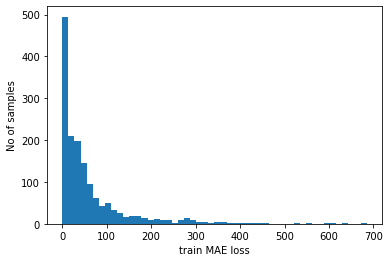

In [20]:
                                # 전체 데이터에 대해서 예측값 - 실제값
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

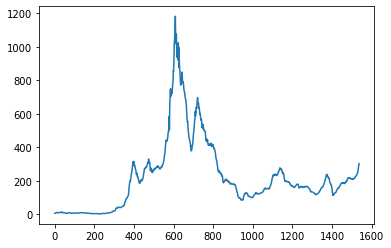

In [21]:
plt.plot(train_pred)

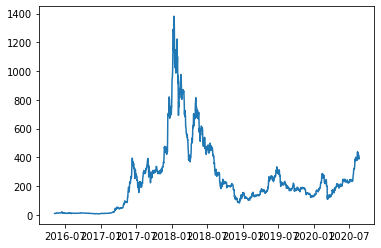

In [22]:
plt.plot(df_train)

In [23]:
train_df_with_pred = df_train.to_frame()[n_steps_in:]
train_df_with_pred['pred'] = train_pred

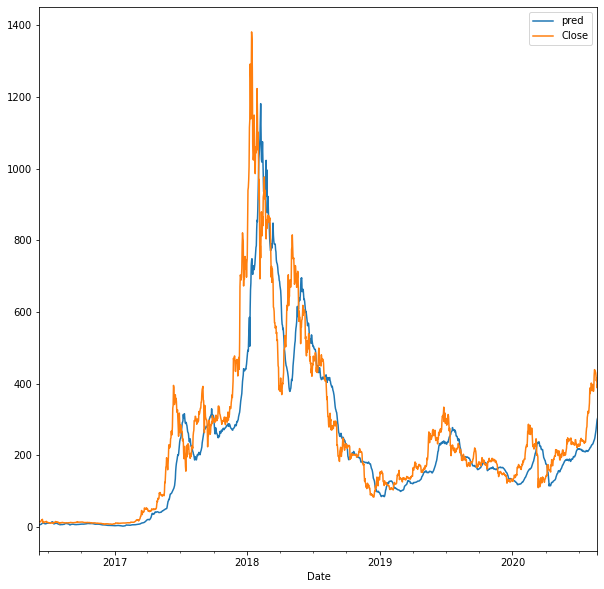

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
train_df_with_pred['pred'].plot(ax=ax, legend=True)
train_df_with_pred['Close'].plot(ax=ax, legend=True)

In [25]:
test_raw_seq = df_test

test_X, test_y = split_sequence(test_raw_seq, n_steps_in, n_steps_out)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [26]:
y_pred = model.predict(test_X)

2/2 [==============================] - 0s 10ms/step


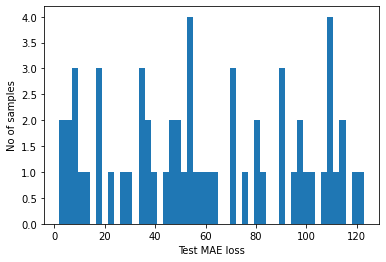

In [27]:
test_mae_loss = np.mean(np.abs(y_pred - test_y), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [28]:
test_df_with_pred = df_test.to_frame()[n_steps_in:]
test_df_with_pred['pred'] = y_pred

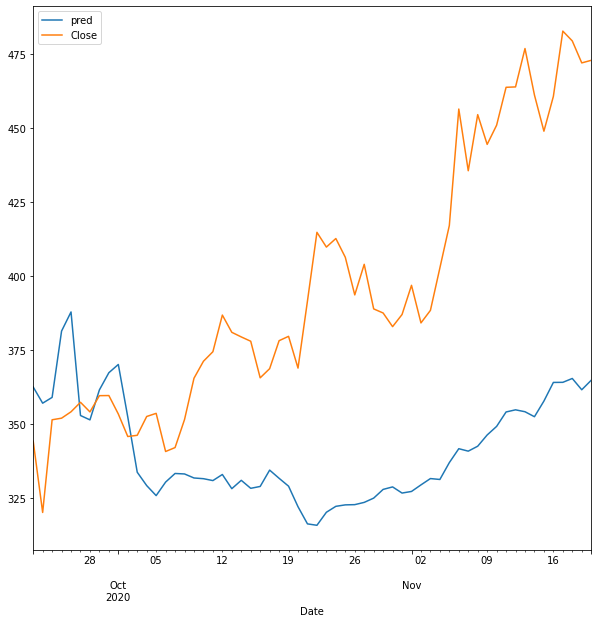

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
test_df_with_pred['pred'].plot(ax=ax, legend=True)
test_df_with_pred['Close'].plot(ax=ax, legend=True)

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

## Multi Step

In [ ]:


raw_seq = df_train

n_steps_in, n_steps_out = 60, 7
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
y

array([[ 11.57,  11.09,  11.13, ...,  10.87,  10.76,  11.52],
       [ 11.09,  11.13,  10.83, ...,  10.76,  11.52,  12.2 ],
       [ 11.13,  10.83,  10.87, ...,  11.52,  12.2 ,  10.2 ],
       ...,
       [438.94, 433.18, 434.  , ..., 422.3 , 407.55, 414.53],
       [433.18, 434.  , 430.74, ..., 407.55, 414.53, 388.07],
       [434.  , 430.74, 422.3 , ..., 414.53, 388.07, 395.98]])

In [ ]:
model = Sequential()
model.add(LSTM(128, activation='relu', 
              #  return_sequences=True, 
               input_shape=(n_steps_in, n_features)))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu'))
# 출력 시계열의 특징이 있다면, 모델링 하는 코드가 들어가야 함.
# 없으면 그냥 쓰면 됨.
model.add(Dense(n_steps_out)) # 7
model.compile(optimizer='adam', loss='mae')

In [ ]:
history = model.fit(X, y, epochs=10, batch_size=64)

Epoch 1/10
24/24 [==============================] - 4s 94ms/step - loss: 227.5251
Epoch 2/10
24/24 [==============================] - 2s 93ms/step - loss: 209.6204
Epoch 3/10
24/24 [==============================] - 2s 92ms/step - loss: 937.7619
Epoch 4/10
24/24 [==============================] - 2s 93ms/step - loss: 1556.0312
Epoch 5/10
24/24 [==============================] - 2s 93ms/step - loss: 852.3376
Epoch 6/10
24/24 [==============================] - 2s 93ms/step - loss: 648.1639
Epoch 7/10
24/24 [==============================] - 2s 94ms/step - loss: 433.4799
Epoch 8/10
24/24 [==============================] - 2s 93ms/step - loss: 351.0766
Epoch 9/10
24/24 [==============================] - 2s 93ms/step - loss: nan
Epoch 10/10
24/24 [==============================] - 2s 90ms/step - loss: nan


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

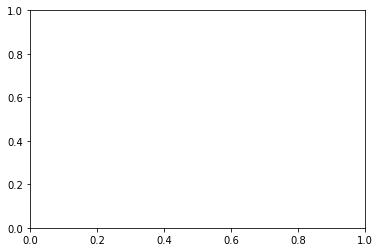

In [ ]:
train_pred = model.predict(X)

train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

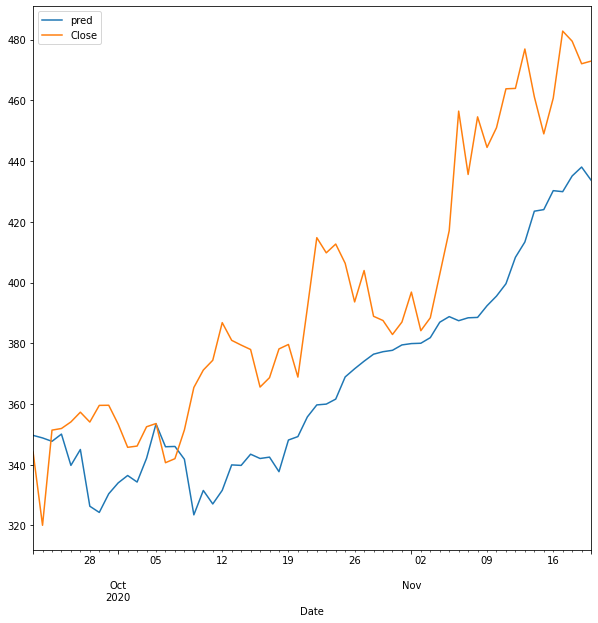

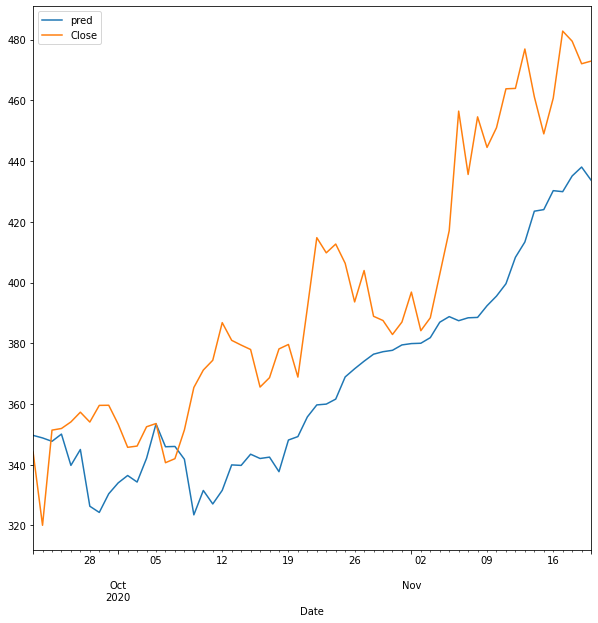

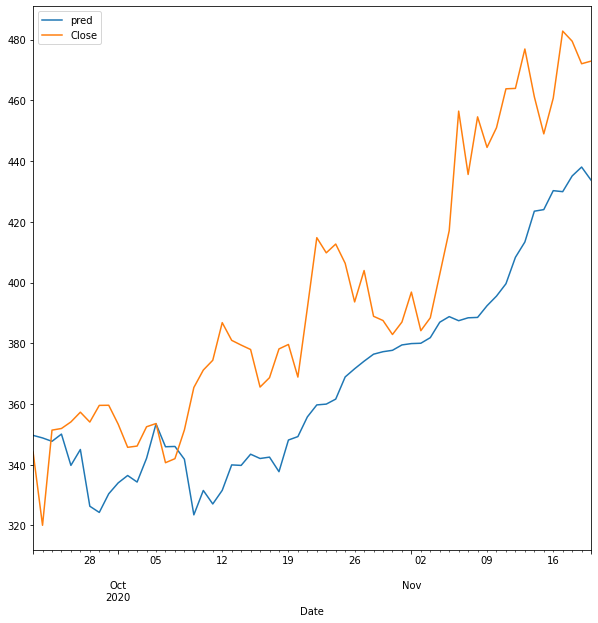

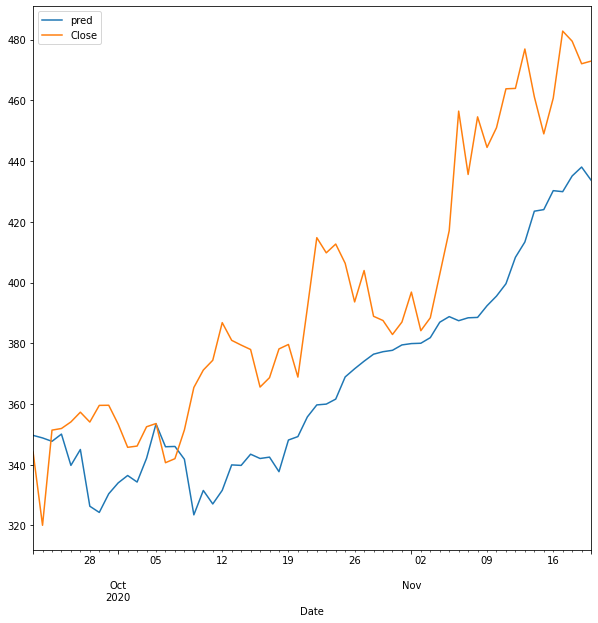

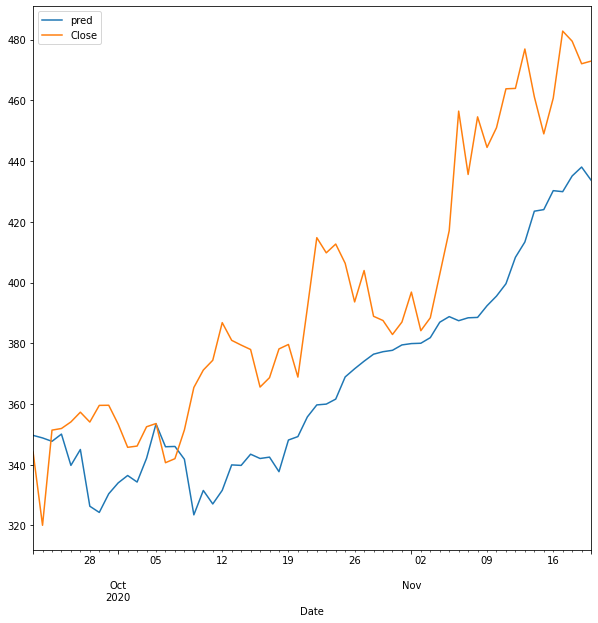

In [ ]:
for i, pred in enumerate(train_pred[:5]):
  train_df_with_pred = df_train[i:i+n_steps_out]
  train_df_with_pred['pred'] = pred
  
  fig, ax = plt.subplots(figsize=(10,10))
  test_df_with_pred['pred'].plot(ax=ax, legend=True)
  test_df_with_pred['Close'].plot(ax=ax, legend=True)
  plt.show()